In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import matplotlib.pyplot as plt
from datetime import datetime
from tempfile import TemporaryFile

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn import metrics
from sklearn.utils import shuffle, class_weight
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.utils import Sequence, plot_model
from keras.constraints import unit_norm
from keras import regularizers
from keras.callbacks import EarlyStopping, Callback, TensorBoard, ReduceLROnPlateau
import keras_metrics as km
from keras.models import load_model

from models.v1 import create_model
from models.custom_metrics import auroc, auprc, recall_m, precision_m, f1_m

#notify the OS about GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'

Using TensorFlow backend.


In [2]:
#parsing command line arguments
# -----parsing command line arguments-----#
parser = argparse.ArgumentParser(description='Training CNN model to predict STARR-seq enhancers based on chromatin accessbility and histone marks')
parser.add_argument('-c', '--cell_types', type=str, help='comma separated string of cell_types')
parser.add_argument('-i', '--in_dir', type=str, help='directory containing 01_data_encoding intermediate tsv files')

#simulate command line input
cmdline_str='-c ' + " HepG2,K562 " + \
    ' -i ' + "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/encoded_2overlap/ATAC/"

seq_names = ["ATAC", "H3K27ac", "H3K4me3", "H3K9ac", "H3K4me1"]

#check if the files are there
args = parser.parse_args(cmdline_str.split())
args.cell_types = args.cell_types.split(",")
for cell in args.cell_types:
    for seq in seq_names:
        pos_file = args.in_dir + cell + "." + seq + ".pos.tsv"
        if not os.path.exists(pos_file):
            print(pos_file + " file does not exist")
            exit(1)
        neg_file = args.in_dir + cell + "." + seq + ".neg.tsv"
        if not os.path.exists(neg_file):
            print(neg_file + " file does not exist")
            exit(1)
print("all files found!")

all files found!


In [3]:
def get_data(cell_types, in_dir, seq_names):

    first_cell = True
    for cell in cell_types:
        print(cell)

        pos = []
        neg = []
        first_seq = True
        for seq in seq_names:
            print("-"+seq)

            pos_name = in_dir+cell+"."+seq+".pos.tsv"
            pos_mat = np.loadtxt(pos_name, delimiter='\t')

            neg_name = in_dir+cell+"."+seq+".neg.tsv"
            neg_mat = np.loadtxt(neg_name, delimiter='\t')

            if first_seq:
                for i in pos_mat:
                    pos.append(np.array([i]))
                for i in neg_mat:
                    neg.append(np.array([i]))
                first_seq = False
            else:
                for i in range(len(pos)):
                    pos[i] = np.vstack((pos[i], pos_mat[i,]))
                for i in range(len(neg)):
                    neg[i] = np.vstack((neg[i], neg_mat[i,]))

        if first_cell == True:
            X_pos = np.array(pos)
            X_neg = np.array(neg)
            first_cell = False
        else:
            X_pos = np.vstack((X_pos, pos))
            X_neg = np.vstack((X_neg, neg))

    X = np.vstack((X_pos, X_neg))
    y = np.array([1 for i in range(X_pos.shape[0])] + [0 for i in range(X_neg.shape[0])]).reshape(-1,1)
    print(X.shape)
    print(y.shape)
    
    return X, y
  
# X, y = get_data(args.cell_types, args.in_dir, seq_names)
# with open(args.in_dir + "hg38_signals.pickle", 'wb') as f:
#     pickle.dump((X,y), f)

In [4]:
with open(args.in_dir + "hg38_signals.pickle", 'rb') as f:
    X, y = pickle.load(f)
window_size = int(X.shape[2] * 10)
X, y = shuffle(X, y, random_state=0)
x_train = np.expand_dims(X, axis=4)
y_train = y

#calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train.flatten())

/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


In [5]:
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# construct the model
model = create_model(width=int(window_size/10))

adam = Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5)
model.compile(loss='binary_crossentropy', optimizer=adam, 
    metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])

#train the model
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.1,
                    shuffle=True,
                    class_weight=class_weights,
                    callbacks=[es]) 

model.save_weights('./saved_models/ATAC_hg38.v1.h5')

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v1.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


Train on 142332 samples, validate on 15815 samples
Epoch 1/100
142332/142332 [==============================] - 132s 930us/step - loss: 0.1644 - acc: 0.9762 - auroc: 0.9468 - auprc: 0.7776 - f1_m: 0.8026 - recall_m: 0.8440 - precision_m: 0.7948 - val_loss: 0.0870 - val_acc: 0.9844 - val_auroc: 0.9911 - val_auprc: 0.9121 - val_f1_m: 0.8876 - val_recall_m: 0.9564 - val_precision_m: 0.8473
Epoch 2/100
142332/142332 [==============================] - 128s 900us/step - loss: 0.0742 - acc: 0.9868 - auroc: 0.9933 - auprc: 0.9292 - f1_m: 0.8795 - recall_m: 0.9168 - precision_m: 0.8651 - val_loss: 0.0648 - val_acc: 0.9875 - val_auroc: 0.9946 - val_auprc: 0.9392 - val_f1_m: 0.9050 - val_recall_m: 0.9560 - val_precision_m: 0.8754
Epoch 3/100
142332/142332 [==============================] - 128s 899us/step - loss: 0.0612 - acc: 0.9885 - auroc: 0.9952 - auprc: 0.9448 - f1_m: 0.8879 - recall_m: 0.9229 - precision_m: 0.8736 - val_loss: 0.0568 - val_acc: 0.9891 - val_auroc: 0.9956 - val_auprc: 0.9487 

Epoch 25/100
142332/142332 [==============================] - 128s 898us/step - loss: 0.0333 - acc: 0.9919 - auroc: 0.9979 - auprc: 0.9734 - f1_m: 0.9073 - recall_m: 0.9319 - precision_m: 0.8970 - val_loss: 0.0342 - val_acc: 0.9915 - val_auroc: 0.9980 - val_auprc: 0.9735 - val_f1_m: 0.9260 - val_recall_m: 0.9478 - val_precision_m: 0.9179
Epoch 26/100
142332/142332 [==============================] - 128s 898us/step - loss: 0.0332 - acc: 0.9918 - auroc: 0.9980 - auprc: 0.9736 - f1_m: 0.9059 - recall_m: 0.9309 - precision_m: 0.8957 - val_loss: 0.0344 - val_acc: 0.9915 - val_auroc: 0.9980 - val_auprc: 0.9737 - val_f1_m: 0.9268 - val_recall_m: 0.9585 - val_precision_m: 0.9087
Epoch 27/100
142332/142332 [==============================] - 128s 899us/step - loss: 0.0327 - acc: 0.9918 - auroc: 0.9980 - auprc: 0.9739 - f1_m: 0.9014 - recall_m: 0.9264 - precision_m: 0.8906 - val_loss: 0.0354 - val_acc: 0.9911 - val_auroc: 0.9980 - val_auprc: 0.9740 - val_f1_m: 0.9231 - val_recall_m: 0.9392 - val_

In [6]:
# --- ENCODE mm10 validation #1 ---#
def rename_tissue(feature):
    feature.name = feature[9]
    return feature

val_file1 = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/ENCFF095OCG.bed"
val_region1 = pybedtools.BedTool(val_file1).each(pybedtools.featurefuncs.midpoint).each(rename_tissue)
val_region1 = val_region1.slop(b=window_size/2, genome="mm10")
val_region1 = val_region1.filter(pybedtools.featurefuncs.greater_than, window_size-1)
val_region1 = val_region1.sort()
val_region1.head()

chr1	13003151	13007152	negative	0	.	13003747	13006556	0,0,255	negative
 chr1	31101021	31105022	negative	0	.	31101599	31104444	0,0,255	negative
 chr1	38197302	38201303	negative	0	.	38196744	38201861	0,0,255	negative
 chr1	39946111	39950112	forebrain [7/9], cranial nerve [7/9], dorsal root ganglion [7/9]	1	.	39945533	39950689	255,0,0	forebrain [7/9], cranial nerve [7/9], dorsal root ganglion [7/9]
 chr1	68778680	68782681	negative	0	.	68779329	68782031	0,0,255	negative
 chr1	75287729	75291730	forebrain [5/12]	1	.	75288287	75291172	255,0,0	forebrain [5/12]
 chr1	75405463	75409464	negative	0	.	75405116	75409810	0,0,255	negative
 chr1	97538619	97542620	forebrain [3/4], midbrain [3/4], hindbrain [3/4], neural tube [3/4]	1	.	97538497	97542741	255,0,0	forebrain [3/4], midbrain [3/4], hindbrain [3/4], neural tube [3/4]
 chr1	127754934	127758935	negative	0	.	127754802	127759066	0,0,255	negative
 chr1	158264756	158268757	midbrain [3/4], hindbrain [3/4], neck [3/4]	1	.	158265467	158268046	255,0,0	m

In [7]:
# --- ENCODE mm10 validation #2 --- #
# val_file2 = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/ENCFF915YMM.bed"
# val_region2 = pybedtools.BedTool(val_file2).each(pybedtools.featurefuncs.midpoint).each(rename_tissue)
# val_region2 = val_region2.slop(b=window_size/2, genome="mm10")
# val_region2 = val_region2.filter(pybedtools.featurefuncs.greater_than, window_size-1)
# val_region2 = val_region2.sort()
# val_region2.head()

In [8]:
# --- VISTA mm9->mm10 validation ---#

val_file3_raw = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/VISTA_mm10_raw.bed"
val_file3_label = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/VISTA_mm9.txt"
val_file3 = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/VISTA_mm10.bed"

df1 = pd.read_csv(val_file3_raw, sep="\t",header=None)
df1_label = pd.read_csv(val_file3_label, sep="\t",header=None)
df1[3] = df1_label[3]
df1.to_csv(val_file3, sep="\t",header=None, index=False)

val_region3 = pybedtools.BedTool(val_file3)
val_region3 = val_region3.each(pybedtools.featurefuncs.midpoint)
val_region3 = val_region3.slop(b=window_size/2, genome="mm10")
val_region3 = val_region3.filter(pybedtools.featurefuncs.greater_than, window_size-1)
val_region3 = val_region3.sort()
val_region3.head()
# print("limb" in val_region3[3][3])

chr1	5020950	5024951	element 911 | negative 
 chr1	9647594	9651595	element 1545 | negative 
 chr1	11025292	11029293	element 659 | negative 
 chr1	12498493	12502494	element 1417 | positive  | limb[5/5] | tail[5/5]
 chr1	12508534	12512535	element 1415 | positive  | limb[9/9]
 chr1	12614067	12618068	element 663 | negative 
 chr1	13003151	13007152	element 1341 | positive  | hindbrain (rhombencephalon)[6/6] | midbrain (mesencephalon)[6/6] | forebrain[6/6] | limb[6/6] | other[3/6]
 chr1	19765625	19769626	element 1771 | negative 
 chr1	31101021	31105022	element 1356 | negative 
 chr1	33988988	33992989	element 664 | negative 
 

In [9]:
# --- merge validation regions from all three sources --- #
# validation_regions = val_region1.cat(val_region2, postmerge=False).cat(val_region3, postmerge=False)
validation_regions = val_region1.cat(val_region3, postmerge=False)
validation_regions.saveas("./mm10/mm10.validation_regions.bed")
# validation_regions.head()

<BedTool(./mm10/mm10.validation_regions.bed)>

In [10]:
# ---- separate positive and negative for each tissue from the files ---- #

def tissue_pos(feature, tissue):
    if tissue in feature.name:
        return True
    else:
        return False

def tissue_neg(feature, tissue):
    if tissue in feature.name:
        return False
    else:
        return True
    
samples = ["forebrain", "heart", "hindbrain", "limb", "midbrain", "neural tube"]
seq_names = ["ATAC-seq", "ChIP-seq.H3K27ac", "ChIP-seq.H3K4me3", "ChIP-seq.H3K9ac", "ChIP-seq.H3K4me1"]
sample_dir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/bigWig/"

In [11]:
# # ---- read in bigwig files ---- #
# def bigWigAverageOverBed(x, bigwig):
# #     print(x)
#     return bigwig.stats(x.chrom, x.start, x.stop, nBins=int(window_size/10))

# def get_signal(region, bigwig):
#     return [bigWigAverageOverBed(x, bigwig) for x in region]

# file_samples = ["forebrain", "heart", "hindbrain", "limb", "midbrain", "neural_tube"]

# peak_set = []
# track_set = []
# for sam in file_samples:
#     all_seq_peak = []
#     all_seq_track = []
#     for seq in seq_names:
#         all_seq_peak.append(sample_dir + sam + "."+ seq + ".narrowPeak")
#         all_seq_track.append(sample_dir + sam + "."+ seq + ".bigWig")
#     peak_set.append(all_seq_peak)
#     track_set.append(all_seq_track)


# # print(track_set)

# X = []
# Y = []
# for i in range(len(samples)):
    
#     #organized per track for all samples
#     signal_X = []
#     signal_Y = []
#     for track in track_set[i]:
#     #   print(track)        
#         pos_bed = pybedtools.BedTool("./mm10/mm10.validation_regions.bed").filter(tissue_pos, samples[i])
#         neg_bed = pybedtools.BedTool("./mm10/mm10.validation_regions.bed").filter(tissue_neg, samples[i])
#         pos = get_signal(pos_bed, pyBigWig.open(track))
#         neg = get_signal(neg_bed, pyBigWig.open(track))

#         x_combined = pos + neg
#         signal_X.append(x_combined)
        
#     print(samples[i], len(pos), len(neg))
        
#     #reorganize per sample for all tracks
#     signal_reform_X = []
#     for j in range(len(x_combined)):
#         per_track_X = []
#         for t in range(len(track_set[i])):
#             per_track_X.append(np.array(signal_X[t][j]))
#         signal_reform_X.append(np.array(per_track_X))
#     signal_reform_X = np.expand_dims(np.array(signal_reform_X), axis=4)
#     X.append(signal_reform_X)
    
#     y_combined = [1 for i in pos] + [0 for i in neg]
#     Y.append(np.array(y_combined))
    
# with open(args.in_dir + "mm10_signals.pickle", 'wb') as f:
#     pickle.dump((X,Y), f)

In [12]:
with open("./mm10/mm10_signals.pickle", 'rb') as f:
    X,Y = pickle.load(f)

In [13]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    y_pred = model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

forebrain validation accuracy is: 0.6723989681857265
heart validation accuracy is: 0.709372312983663
hindbrain validation accuracy is: 0.6981943250214961
limb validation accuracy is: 0.6835769561478934
midbrain validation accuracy is: 0.6638005159071367
neural tube validation accuracy is: 0.705073086844368


In [14]:
y_pred_list = []
accuracy_list = []
for i in range(len(samples)):
    
    #fine-tuning
    X_ft = X.copy()
    X_ft.pop(i)
    X_ft = np.array(X_ft)
    X_ft = X_ft.reshape((-1, X_ft.shape[2], X_ft.shape[3], X_ft.shape[4]))
    
    Y_ft = Y.copy()
    Y_ft.pop(i)
    Y_ft = np.array(Y_ft)
    Y_ft = Y_ft.reshape((-1, 1))
    
    X_ft, Y_ft = shuffle(X_ft, Y_ft, random_state=0)
    
    class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(Y_ft),
                                                  Y_ft.flatten())
    
    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    ft_model = create_model(width=int(window_size/10))
    ft_model.load_weights('./saved_models/ATAC_hg38.v1.h5')
    ft_model.compile(loss='binary_crossentropy', 
                     optimizer=Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=9e-5), 
                     metrics=['accuracy', auroc, auprc, f1_m, recall_m, precision_m])
    
    #train the model
    history = ft_model.fit(X_ft, Y_ft,
                        batch_size=4,
                        epochs=100,
                        validation_split=0.1,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[es])
    
    

    y_pred = ft_model.predict(X[i]).ravel()
    y_pred_list.append(y_pred)

    accuracy_s = sklearn.metrics.accuracy_score(Y[i], np.rint(y_pred))
    print(samples[i], "validation accuracy is:", accuracy_s)
    accuracy_list.append(accuracy_s)

/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/models/v1.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  model = Model(input=[input_size], output=[pred_output])


Train on 5233 samples, validate on 582 samples
Epoch 1/100
5233/5233 [==============================] - 24s 4ms/step - loss: 0.6769 - acc: 0.7737 - auroc: 0.6806 - auprc: 0.2259 - f1_m: 0.1305 - recall_m: 0.1455 - precision_m: 0.1323 - val_loss: 0.5439 - val_acc: 0.8711 - val_auroc: 0.6620 - val_auprc: 0.2210 - val_f1_m: 0.0412 - val_recall_m: 0.0412 - val_precision_m: 0.0412
Epoch 2/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4637 - acc: 0.8588 - auroc: 0.6618 - auprc: 0.2203 - f1_m: 0.0204 - recall_m: 0.0199 - precision_m: 0.0218 - val_loss: 0.4812 - val_acc: 0.8711 - val_auroc: 0.6574 - val_auprc: 0.2168 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 3/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4381 - acc: 0.8601 - auroc: 0.6544 - auprc: 0.2136 - f1_m: 0.0036 - recall_m: 0.0032 - precision_m: 0.0046 - val_loss: 0.4558 - val_acc: 0.8729 - val_auroc: 0.6515 - val_auprc: 0.2122 - val_f1_m: 0.0000e+00 - 

5233/5233 [==============================] - 21s 4ms/step - loss: 0.3902 - acc: 0.8626 - auroc: 0.6627 - auprc: 0.2368 - f1_m: 0.0153 - recall_m: 0.0145 - precision_m: 0.0168 - val_loss: 0.3934 - val_acc: 0.8763 - val_auroc: 0.6629 - val_auprc: 0.2371 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 26/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3913 - acc: 0.8615 - auroc: 0.6634 - auprc: 0.2376 - f1_m: 0.0108 - recall_m: 0.0097 - precision_m: 0.0130 - val_loss: 0.3931 - val_acc: 0.8763 - val_auroc: 0.6636 - val_auprc: 0.2380 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 27/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3897 - acc: 0.8615 - auroc: 0.6640 - auprc: 0.2385 - f1_m: 0.0147 - recall_m: 0.0138 - precision_m: 0.0164 - val_loss: 0.3926 - val_acc: 0.8763 - val_auroc: 0.6645 - val_auprc: 0.2390 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 28/100
5

Epoch 50/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3869 - acc: 0.8632 - auroc: 0.6753 - auprc: 0.2555 - f1_m: 0.0203 - recall_m: 0.0190 - precision_m: 0.0233 - val_loss: 0.3875 - val_acc: 0.8763 - val_auroc: 0.6753 - val_auprc: 0.2556 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 51/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3875 - acc: 0.8626 - auroc: 0.6755 - auprc: 0.2558 - f1_m: 0.0130 - recall_m: 0.0116 - precision_m: 0.0161 - val_loss: 0.3874 - val_acc: 0.8763 - val_auroc: 0.6756 - val_auprc: 0.2561 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 52/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3859 - acc: 0.8616 - auroc: 0.6758 - auprc: 0.2565 - f1_m: 0.0147 - recall_m: 0.0136 - precision_m: 0.0168 - val_loss: 0.3872 - val_acc: 0.8763 - val_auroc: 0.6759 - val_auprc: 0.2566 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 75/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3848 - acc: 0.8632 - auroc: 0.6816 - auprc: 0.2655 - f1_m: 0.0192 - recall_m: 0.0190 - precision_m: 0.0206 - val_loss: 0.3848 - val_acc: 0.8763 - val_auroc: 0.6817 - val_auprc: 0.2656 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 76/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3848 - acc: 0.8618 - auroc: 0.6818 - auprc: 0.2658 - f1_m: 0.0172 - recall_m: 0.0164 - precision_m: 0.0195 - val_loss: 0.3848 - val_acc: 0.8763 - val_auroc: 0.6819 - val_auprc: 0.2660 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 77/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3814 - acc: 0.8647 - auroc: 0.6820 - auprc: 0.2662 - f1_m: 0.0200 - recall_m: 0.0189 - precision_m: 0.0229 - val_loss: 0.3847 - val_acc: 0.8763 - val_auroc: 0.6822 - val_auprc: 0.2664 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 100/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3836 - acc: 0.8615 - auroc: 0.6862 - auprc: 0.2725 - f1_m: 0.0172 - recall_m: 0.0166 - precision_m: 0.0191 - val_loss: 0.3830 - val_acc: 0.8763 - val_auroc: 0.6862 - val_auprc: 0.2726 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
forebrain validation accuracy is: 0.8349097162510748
Train on 5233 samples, validate on 582 samples
Epoch 1/100
5233/5233 [==============================] - 23s 4ms/step - loss: 0.6967 - acc: 0.7749 - auroc: 0.6606 - auprc: 0.2363 - f1_m: 0.1314 - recall_m: 0.1519 - precision_m: 0.1280 - val_loss: 0.5514 - val_acc: 0.8660 - val_auroc: 0.6558 - val_auprc: 0.2251 - val_f1_m: 0.0206 - val_recall_m: 0.0206 - val_precision_m: 0.0206
Epoch 2/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4706 - acc: 0.8563 - auroc: 0.6542 - auprc: 0.2217 - f1_m: 0.0200 - recall_m: 0.0189 - precision_m: 0.0222 - val_loss: 0.4826 - val_acc: 0.8694 - val_auro

5233/5233 [==============================] - 21s 4ms/step - loss: 0.3995 - acc: 0.8590 - auroc: 0.6554 - auprc: 0.2366 - f1_m: 0.0141 - recall_m: 0.0129 - precision_m: 0.0168 - val_loss: 0.3990 - val_acc: 0.8729 - val_auroc: 0.6557 - val_auprc: 0.2372 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 25/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3994 - acc: 0.8592 - auroc: 0.6561 - auprc: 0.2378 - f1_m: 0.0152 - recall_m: 0.0144 - precision_m: 0.0168 - val_loss: 0.3985 - val_acc: 0.8729 - val_auroc: 0.6567 - val_auprc: 0.2385 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 26/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3986 - acc: 0.8586 - auroc: 0.6571 - auprc: 0.2390 - f1_m: 0.0176 - recall_m: 0.0163 - precision_m: 0.0206 - val_loss: 0.3981 - val_acc: 0.8729 - val_auroc: 0.6575 - val_auprc: 0.2395 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 27/100
5

Epoch 49/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3984 - acc: 0.8603 - auroc: 0.6686 - auprc: 0.2554 - f1_m: 0.0217 - recall_m: 0.0206 - precision_m: 0.0237 - val_loss: 0.3943 - val_acc: 0.8729 - val_auroc: 0.6687 - val_auprc: 0.2558 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 50/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3968 - acc: 0.8592 - auroc: 0.6690 - auprc: 0.2562 - f1_m: 0.0203 - recall_m: 0.0190 - precision_m: 0.0229 - val_loss: 0.3941 - val_acc: 0.8729 - val_auroc: 0.6691 - val_auprc: 0.2563 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 51/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3955 - acc: 0.8603 - auroc: 0.6694 - auprc: 0.2566 - f1_m: 0.0187 - recall_m: 0.0171 - precision_m: 0.0225 - val_loss: 0.3939 - val_acc: 0.8729 - val_auroc: 0.6694 - val_auprc: 0.2568 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
E

Epoch 74/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3943 - acc: 0.8590 - auroc: 0.6753 - auprc: 0.2664 - f1_m: 0.0219 - recall_m: 0.0204 - precision_m: 0.0252 - val_loss: 0.3920 - val_acc: 0.8729 - val_auroc: 0.6754 - val_auprc: 0.2664 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 75/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3917 - acc: 0.8611 - auroc: 0.6755 - auprc: 0.2666 - f1_m: 0.0236 - recall_m: 0.0231 - precision_m: 0.0255 - val_loss: 0.3919 - val_acc: 0.8729 - val_auroc: 0.6756 - val_auprc: 0.2668 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 76/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3930 - acc: 0.8594 - auroc: 0.6758 - auprc: 0.2671 - f1_m: 0.0229 - recall_m: 0.0218 - precision_m: 0.0252 - val_loss: 0.3918 - val_acc: 0.8729 - val_auroc: 0.6758 - val_auprc: 0.2672 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
E

Epoch 99/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3906 - acc: 0.8597 - auroc: 0.6796 - auprc: 0.2735 - f1_m: 0.0215 - recall_m: 0.0196 - precision_m: 0.0256 - val_loss: 0.3906 - val_acc: 0.8729 - val_auroc: 0.6796 - val_auprc: 0.2736 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 100/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3853 - acc: 0.8599 - auroc: 0.6798 - auprc: 0.2738 - f1_m: 0.0222 - recall_m: 0.0213 - precision_m: 0.0245 - val_loss: 0.3906 - val_acc: 0.8729 - val_auroc: 0.6799 - val_auprc: 0.2739 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
heart validation accuracy is: 0.8460877042132416
Train on 5233 samples, validate on 582 samples
Epoch 1/100
5233/5233 [==============================] - 23s 4ms/step - loss: 0.7018 - acc: 0.7678 - auroc: 0.6587 - auprc: 0.2477 - f1_m: 0.1324 - recall_m: 0.1513 - precision_m: 0.1323 - val_loss: 0.5482 - val_acc: 0.8557 - val_auroc: 

5233/5233 [==============================] - 21s 4ms/step - loss: 0.4040 - acc: 0.8553 - auroc: 0.6604 - auprc: 0.2404 - f1_m: 0.0144 - recall_m: 0.0134 - precision_m: 0.0168 - val_loss: 0.4004 - val_acc: 0.8694 - val_auroc: 0.6609 - val_auprc: 0.2411 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 24/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4061 - acc: 0.8561 - auroc: 0.6615 - auprc: 0.2420 - f1_m: 0.0177 - recall_m: 0.0159 - precision_m: 0.0214 - val_loss: 0.3999 - val_acc: 0.8694 - val_auroc: 0.6618 - val_auprc: 0.2423 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 25/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4054 - acc: 0.8542 - auroc: 0.6621 - auprc: 0.2427 - f1_m: 0.0120 - recall_m: 0.0115 - precision_m: 0.0130 - val_loss: 0.3996 - val_acc: 0.8694 - val_auroc: 0.6624 - val_auprc: 0.2431 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 26/100
5

Epoch 48/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3978 - acc: 0.8594 - auroc: 0.6738 - auprc: 0.2594 - f1_m: 0.0255 - recall_m: 0.0245 - precision_m: 0.0279 - val_loss: 0.3942 - val_acc: 0.8694 - val_auroc: 0.6740 - val_auprc: 0.2596 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 49/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3981 - acc: 0.8571 - auroc: 0.6742 - auprc: 0.2598 - f1_m: 0.0225 - recall_m: 0.0218 - precision_m: 0.0248 - val_loss: 0.3940 - val_acc: 0.8694 - val_auroc: 0.6743 - val_auprc: 0.2600 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 50/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4005 - acc: 0.8559 - auroc: 0.6746 - auprc: 0.2605 - f1_m: 0.0187 - recall_m: 0.0178 - precision_m: 0.0206 - val_loss: 0.3939 - val_acc: 0.8694 - val_auroc: 0.6747 - val_auprc: 0.2606 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 73/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3967 - acc: 0.8561 - auroc: 0.6811 - auprc: 0.2695 - f1_m: 0.0201 - recall_m: 0.0187 - precision_m: 0.0229 - val_loss: 0.3908 - val_acc: 0.8694 - val_auroc: 0.6812 - val_auprc: 0.2697 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 74/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3949 - acc: 0.8563 - auroc: 0.6813 - auprc: 0.2699 - f1_m: 0.0161 - recall_m: 0.0150 - precision_m: 0.0183 - val_loss: 0.3907 - val_acc: 0.8694 - val_auroc: 0.6815 - val_auprc: 0.2700 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 75/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3969 - acc: 0.8567 - auroc: 0.6816 - auprc: 0.2701 - f1_m: 0.0145 - recall_m: 0.0134 - precision_m: 0.0168 - val_loss: 0.3906 - val_acc: 0.8694 - val_auroc: 0.6817 - val_auprc: 0.2703 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 98/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3929 - acc: 0.8559 - auroc: 0.6859 - auprc: 0.2764 - f1_m: 0.0185 - recall_m: 0.0180 - precision_m: 0.0199 - val_loss: 0.3885 - val_acc: 0.8694 - val_auroc: 0.6860 - val_auprc: 0.2764 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 99/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3934 - acc: 0.8557 - auroc: 0.6860 - auprc: 0.2765 - f1_m: 0.0144 - recall_m: 0.0130 - precision_m: 0.0176 - val_loss: 0.3885 - val_acc: 0.8694 - val_auroc: 0.6861 - val_auprc: 0.2767 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 100/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3914 - acc: 0.8573 - auroc: 0.6863 - auprc: 0.2769 - f1_m: 0.0201 - recall_m: 0.0187 - precision_m: 0.0233 - val_loss: 0.3884 - val_acc: 0.8694 - val_auroc: 0.6864 - val_auprc: 0.2770 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137


5233/5233 [==============================] - 21s 4ms/step - loss: 0.4006 - acc: 0.8601 - auroc: 0.6630 - auprc: 0.2389 - f1_m: 0.0154 - recall_m: 0.0144 - precision_m: 0.0176 - val_loss: 0.3763 - val_acc: 0.8729 - val_auroc: 0.6635 - val_auprc: 0.2394 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 23/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3960 - acc: 0.8595 - auroc: 0.6639 - auprc: 0.2400 - f1_m: 0.0129 - recall_m: 0.0117 - precision_m: 0.0153 - val_loss: 0.3759 - val_acc: 0.8729 - val_auroc: 0.6646 - val_auprc: 0.2405 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 24/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3952 - acc: 0.8607 - auroc: 0.6652 - auprc: 0.2411 - f1_m: 0.0178 - recall_m: 0.0168 - precision_m: 0.0199 - val_loss: 0.3755 - val_acc: 0.8729 - val_auroc: 0.6656 - val_auprc: 0.2416 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 25/100
5

Epoch 47/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3967 - acc: 0.8609 - auroc: 0.6783 - auprc: 0.2589 - f1_m: 0.0205 - recall_m: 0.0191 - precision_m: 0.0237 - val_loss: 0.3701 - val_acc: 0.8729 - val_auroc: 0.6784 - val_auprc: 0.2591 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 48/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3916 - acc: 0.8626 - auroc: 0.6786 - auprc: 0.2595 - f1_m: 0.0240 - recall_m: 0.0227 - precision_m: 0.0271 - val_loss: 0.3700 - val_acc: 0.8729 - val_auroc: 0.6787 - val_auprc: 0.2597 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 49/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3879 - acc: 0.8630 - auroc: 0.6791 - auprc: 0.2602 - f1_m: 0.0241 - recall_m: 0.0222 - precision_m: 0.0283 - val_loss: 0.3698 - val_acc: 0.8729 - val_auroc: 0.6793 - val_auprc: 0.2605 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 72/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3898 - acc: 0.8603 - auroc: 0.6862 - auprc: 0.2708 - f1_m: 0.0173 - recall_m: 0.0161 - precision_m: 0.0199 - val_loss: 0.3673 - val_acc: 0.8746 - val_auroc: 0.6863 - val_auprc: 0.2710 - val_f1_m: 0.0206 - val_recall_m: 0.0206 - val_precision_m: 0.0206
Epoch 73/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3887 - acc: 0.8622 - auroc: 0.6863 - auprc: 0.2711 - f1_m: 0.0196 - recall_m: 0.0183 - precision_m: 0.0222 - val_loss: 0.3673 - val_acc: 0.8746 - val_auroc: 0.6865 - val_auprc: 0.2713 - val_f1_m: 0.0206 - val_recall_m: 0.0206 - val_precision_m: 0.0206
Epoch 74/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3920 - acc: 0.8603 - auroc: 0.6865 - auprc: 0.2715 - f1_m: 0.0176 - recall_m: 0.0164 - precision_m: 0.0199 - val_loss: 0.3672 - val_acc: 0.8746 - val_auroc: 0.6866 - val_auprc: 0.2716 - val_f1_m: 0.0206 - val_recall_m: 0.0206 - val_precision_m: 0.0206
E

Epoch 97/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3872 - acc: 0.8599 - auroc: 0.6907 - auprc: 0.2783 - f1_m: 0.0190 - recall_m: 0.0185 - precision_m: 0.0206 - val_loss: 0.3656 - val_acc: 0.8763 - val_auroc: 0.6907 - val_auprc: 0.2784 - val_f1_m: 0.0206 - val_recall_m: 0.0206 - val_precision_m: 0.0206
Epoch 98/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3870 - acc: 0.8615 - auroc: 0.6908 - auprc: 0.2785 - f1_m: 0.0180 - recall_m: 0.0171 - precision_m: 0.0199 - val_loss: 0.3656 - val_acc: 0.8763 - val_auroc: 0.6909 - val_auprc: 0.2786 - val_f1_m: 0.0206 - val_recall_m: 0.0206 - val_precision_m: 0.0206
Epoch 99/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3896 - acc: 0.8611 - auroc: 0.6909 - auprc: 0.2787 - f1_m: 0.0180 - recall_m: 0.0165 - precision_m: 0.0214 - val_loss: 0.3655 - val_acc: 0.8763 - val_auroc: 0.6910 - val_auprc: 0.2788 - val_f1_m: 0.0206 - val_recall_m: 0.0206 - val_precision_m: 0.0206
E

5233/5233 [==============================] - 21s 4ms/step - loss: 0.3965 - acc: 0.8586 - auroc: 0.6729 - auprc: 0.2415 - f1_m: 0.0111 - recall_m: 0.0103 - precision_m: 0.0130 - val_loss: 0.3714 - val_acc: 0.8729 - val_auroc: 0.6735 - val_auprc: 0.2421 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 22/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3967 - acc: 0.8594 - auroc: 0.6737 - auprc: 0.2423 - f1_m: 0.0130 - recall_m: 0.0122 - precision_m: 0.0145 - val_loss: 0.3709 - val_acc: 0.8729 - val_auroc: 0.6743 - val_auprc: 0.2431 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 23/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3987 - acc: 0.8576 - auroc: 0.6747 - auprc: 0.2436 - f1_m: 0.0107 - recall_m: 0.0099 - precision_m: 0.0122 - val_loss: 0.3705 - val_acc: 0.8729 - val_auroc: 0.6750 - val_auprc: 0.2440 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 24/100
5

Epoch 46/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3907 - acc: 0.8595 - auroc: 0.6875 - auprc: 0.2630 - f1_m: 0.0194 - recall_m: 0.0181 - precision_m: 0.0225 - val_loss: 0.3645 - val_acc: 0.8729 - val_auroc: 0.6877 - val_auprc: 0.2632 - val_f1_m: 0.0069 - val_recall_m: 0.0069 - val_precision_m: 0.0069
Epoch 47/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3903 - acc: 0.8595 - auroc: 0.6879 - auprc: 0.2636 - f1_m: 0.0143 - recall_m: 0.0135 - precision_m: 0.0161 - val_loss: 0.3643 - val_acc: 0.8746 - val_auroc: 0.6881 - val_auprc: 0.2638 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 48/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3906 - acc: 0.8603 - auroc: 0.6882 - auprc: 0.2640 - f1_m: 0.0168 - recall_m: 0.0154 - precision_m: 0.0199 - val_loss: 0.3641 - val_acc: 0.8746 - val_auroc: 0.6884 - val_auprc: 0.2643 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 71/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3877 - acc: 0.8611 - auroc: 0.6953 - auprc: 0.2746 - f1_m: 0.0227 - recall_m: 0.0210 - precision_m: 0.0264 - val_loss: 0.3612 - val_acc: 0.8746 - val_auroc: 0.6954 - val_auprc: 0.2749 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 72/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3862 - acc: 0.8584 - auroc: 0.6956 - auprc: 0.2750 - f1_m: 0.0154 - recall_m: 0.0143 - precision_m: 0.0183 - val_loss: 0.3611 - val_acc: 0.8746 - val_auroc: 0.6957 - val_auprc: 0.2753 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 73/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3872 - acc: 0.8592 - auroc: 0.6958 - auprc: 0.2755 - f1_m: 0.0177 - recall_m: 0.0164 - precision_m: 0.0206 - val_loss: 0.3610 - val_acc: 0.8746 - val_auroc: 0.6960 - val_auprc: 0.2757 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 96/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3892 - acc: 0.8597 - auroc: 0.7000 - auprc: 0.2822 - f1_m: 0.0183 - recall_m: 0.0177 - precision_m: 0.0199 - val_loss: 0.3593 - val_acc: 0.8746 - val_auroc: 0.7001 - val_auprc: 0.2823 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 97/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3877 - acc: 0.8597 - auroc: 0.7002 - auprc: 0.2826 - f1_m: 0.0209 - recall_m: 0.0203 - precision_m: 0.0225 - val_loss: 0.3592 - val_acc: 0.8746 - val_auroc: 0.7002 - val_auprc: 0.2826 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 98/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.3858 - acc: 0.8594 - auroc: 0.7003 - auprc: 0.2827 - f1_m: 0.0180 - recall_m: 0.0167 - precision_m: 0.0206 - val_loss: 0.3592 - val_acc: 0.8746 - val_auroc: 0.7003 - val_auprc: 0.2828 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 20/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4233 - acc: 0.8460 - auroc: 0.6595 - auprc: 0.2504 - f1_m: 0.0193 - recall_m: 0.0180 - precision_m: 0.0224 - val_loss: 0.3649 - val_acc: 0.8694 - val_auroc: 0.6600 - val_auprc: 0.2511 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 21/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4218 - acc: 0.8473 - auroc: 0.6603 - auprc: 0.2516 - f1_m: 0.0203 - recall_m: 0.0187 - precision_m: 0.0237 - val_loss: 0.3642 - val_acc: 0.8694 - val_auroc: 0.6611 - val_auprc: 0.2525 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 22/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4211 - acc: 0.8466 - auroc: 0.6616 - auprc: 0.2532 - f1_m: 0.0241 - recall_m: 0.0220 - precision_m: 0.0283 - val_loss: 0.3639 - val_acc: 0.8694 - val_auroc: 0.6621 - val_auprc: 0.2537 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

Epoch 45/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4144 - acc: 0.8467 - auroc: 0.6781 - auprc: 0.2753 - f1_m: 0.0196 - recall_m: 0.0177 - precision_m: 0.0237 - val_loss: 0.3588 - val_acc: 0.8694 - val_auroc: 0.6782 - val_auprc: 0.2756 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 46/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4150 - acc: 0.8458 - auroc: 0.6784 - auprc: 0.2758 - f1_m: 0.0199 - recall_m: 0.0185 - precision_m: 0.0233 - val_loss: 0.3586 - val_acc: 0.8694 - val_auroc: 0.6786 - val_auprc: 0.2762 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
Epoch 47/100
5233/5233 [==============================] - 21s 4ms/step - loss: 0.4129 - acc: 0.8462 - auroc: 0.6788 - auprc: 0.2765 - f1_m: 0.0228 - recall_m: 0.0217 - precision_m: 0.0252 - val_loss: 0.3584 - val_acc: 0.8694 - val_auroc: 0.6791 - val_auprc: 0.2768 - val_f1_m: 0.0137 - val_recall_m: 0.0137 - val_precision_m: 0.0137
E

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


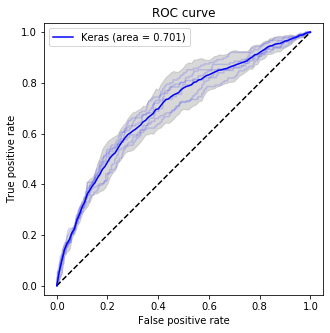

In [15]:
# ROC in test set
plt.figure(figsize=(5, 5))
base_fpr = np.linspace(0, 1, 101)
tpr_list = []
auroc_list = []
for i in range(len(Y)):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y[i], y_pred_list[i])
    auroc_list.append(sklearn.metrics.roc_auc_score(Y[i], y_pred_list[i]))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tpr_list.append(tpr)

print(len(tpr_list), len(tpr_list[0]), len(tpr_list[1]))
tpr_list = np.array(tpr_list)
mean_tpr = np.mean(np.array(tpr_list), axis=0)
tpr_std = tpr_list.std(axis=0)

tprs_upper = np.minimum(mean_tpr + 2 * tpr_std, 1)
tprs_lower = mean_tpr - 2 * tpr_std

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(base_fpr, mean_tpr, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auroc_list))))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.ROC.png')

6 101 101


/gpfs/ysm/project/zc264/conda_envs/old_keras_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


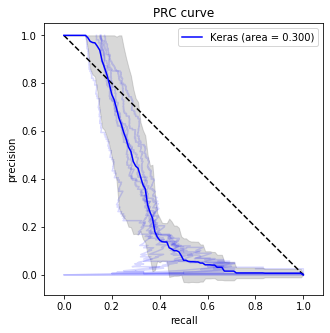

In [16]:
# PRC in test set
plt.figure(figsize=(5, 5))
base_recall = np.linspace(0, 1, 101)
precision_list = []
auprc_list = []
for i in range(len(Y)):
    recall, precision, thresholds = sklearn.metrics.precision_recall_curve(Y[i], y_pred_list[i])
    auprc_list.append(sklearn.metrics.average_precision_score(Y[i], y_pred_list[i]))
    plt.plot(recall, precision, 'b', alpha=0.15)
    precision = np.interp(base_recall, recall, precision)
    precision[0] = 1.0
    precision_list.append(precision)

print(len(precision_list), len(precision_list[0]), len(precision_list[1]))
precision_list = np.array(precision_list)
mean_precision = np.mean(np.array(precision_list), axis=0)
precision_std = precision_list.std(axis=0)

precisions_upper = np.minimum(mean_precision + 2 * precision_std, 1)
precisions_lower = mean_precision - 2 * precision_std

plt.plot([0, 1], [1, 0], 'k--')
plt.plot(base_recall, mean_precision, 'b', label='Keras (area = {:.3f})'.format(np.mean(np.array(auprc_list))))
plt.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.3)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PRC curve')
plt.legend(loc='best')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig(figure_output_name+'.PRC.png')

In [17]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auROC: " + str(auroc_list[i]))

validated tissue forebrain auROC: 0.715299851663488
validated tissue heart auROC: 0.7292914979757085
validated tissue hindbrain auROC: 0.718817667244938
validated tissue limb auROC: 0.6781861743198437
validated tissue midbrain auROC: 0.665867340507214
validated tissue neural tube auROC: 0.6974036522018529


In [18]:
for i in range(len(samples)):
    print("validated tissue " + samples[i] + " auPRC: " + str(auprc_list[i]))

validated tissue forebrain auPRC: 0.34596635085358773
validated tissue heart auPRC: 0.30473454656114474
validated tissue hindbrain auPRC: 0.32167512887790006
validated tissue limb auPRC: 0.2966129017530563
validated tissue midbrain auPRC: 0.30728778995383305
validated tissue neural tube auPRC: 0.22462405290591023
